# **1. 라이브러리 및 데이터**
* 필요 라이브러리 선언

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 2. **이미지 및 레이블**
* 이미지 사이즈 조절 및 정규화용 함수

In [2]:
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
    img = cv2.resize(img, (256, 256))               
    img = np.array(img, dtype='float32')            
    img = img/255                                   
    return img

* 이미지 및 레이블 관리

In [3]:
X_train = []
y_train = []

train_path = "./train/"

* 이미지와 레이블 불러오기

In [4]:
for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0)
        elif folder.name[0]=='V':
            y_train.append(1)
        else:
            y_train.append(2)

# **3. 데이터 전처리**
* X-train 및 y_train 내용 확인

In [5]:
X_train = np.array(X_train)
X_train.shape

(557, 256, 256, 3)

In [6]:
y_train = np.array(y_train)
y_train.shape

(557,)

* 레이블별 데이터 갯수 시각화

<BarContainer object of 3 artists>

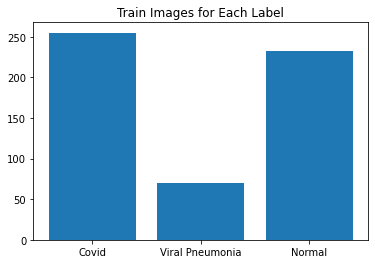

In [7]:
covid_count = len(y_train[y_train==0])
pneumonia_count = len(y_train[y_train==1])
normal_count = len(y_train[y_train==2])

plt.title("Train Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

* 데이터 증대를 위해 영상 좌우 반전

In [8]:
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])
    X_aug.append(X_new)
    y_aug.append(y_train[i])

X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

* 증배된 데이터 확인

In [9]:
X_train = np.append(X_train, X_aug, axis=0)
X_train.shape

(1114, 256, 256, 3)

In [10]:
y_train = np.append(y_train, y_aug, axis=0)
y_train.shape

(1114,)

* 검증 이미지 불러오기 및 확인

In [11]:
X_val = []
y_val = []

val_path = './test/'

for folder in os.scandir(val_path):
    for entry in os.scandir(val_path + folder.name):

        X_val.append(read_and_preprocess(val_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_val.append(0)
        elif folder.name[0]=='V':
            y_val.append(1)
        else:
            y_val.append(2)
            
X_val = np.array(X_val)
y_val = np.array(y_val)

In [12]:
X_val.shape

(124, 256, 256, 3)

* 레이블별 데이터 갯수 시각화

<BarContainer object of 3 artists>

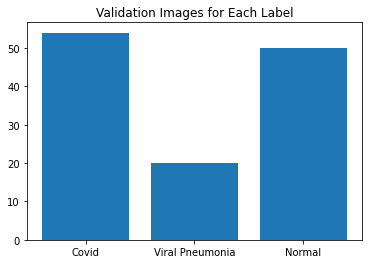

In [13]:
covid_count = len(y_val[y_val==0])
pneumonia_count = len(y_val[y_val==1])
normal_count = len(y_val[y_val==2])

plt.title("Validation Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

# **4. 모델 구축**
* 전이학습을 위한 모델 생성(베이스모델 : VGG16)

In [14]:
basemodel = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

* 모델 레이어 확인

In [15]:
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

* 베이스 모델 가중치 변경 금지 설정

In [16]:
for layer in basemodel.layers:
  layers.trainable = False

* 사용 안함
* 베이스모델 뒤에 추가 레이어 쌓기
* C-C-P-FC-dropout-FC 모델

In [17]:
#headmodel = basemodel.output
#headmodel = Dense(32, activation = 'relu')(headmodel)
#headmodel = Dense(64, activation = 'relu')(headmodel)
#headmodel = Dropout(0.25)(headmodel)
#headmodel = Flatten(name= 'flatten')(headmodel)
#headmodel = Dense(128, activation = 'relu')(headmodel)
#headmodel = Dropout(0.5)(headmodel)
#headmodel = Dense(3, activation = 'softmax')(headmodel)

#model = Model(inputs = basemodel.input, outputs = headmodel)

* 사용 안함
* Dropout-FC 모델

In [19]:
#headmodel = basemodel.output
#headmodel = Flatten(name= 'flatten')(headmodel)
#headmodel = Dense(32, activation = 'relu')(headmodel)
#headmodel = Dropout(0.25)(headmodel)
#headmodel = Dense(3, activation = 'softmax')(headmodel)

#model = Model(inputs = basemodel.input, outputs = headmodel)

* 사용
* FC 모델

In [18]:
headmodel = basemodel.output
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

* 쌓은 모델 레이어 확인

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

* 옵티마이저 선언

In [21]:
opt = optimizers.Adam(learning_rate=0.0001)

* 모델 컴파일

In [22]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

* 조기종료 설정

In [23]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

* 모델 자동저장 설정

In [24]:
checkpointer = ModelCheckpoint(filepath="covid_classifier_weights.h5", verbose=1, save_best_only=True)

# **5. 모델 학습**
* 모델 학습 시작

* 사용
* 배치사이즈 16

In [25]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=16, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
70/70 [==============================] - 26s 206ms/step - loss: 0.3450 - accuracy: 0.8654 - val_loss: 0.1540 - val_accuracy: 0.9113

Epoch 00001: val_loss improved from inf to 0.15399, saving model to covid_classifier_weights.h5
Epoch 2/100
70/70 [==============================] - 10s 137ms/step - loss: 0.0791 - accuracy: 0.9686 - val_loss: 0.2714 - val_accuracy: 0.9113

Epoch 00002: val_loss did not improve from 0.15399
Epoch 3/100
70/70 [==============================] - 10s 141ms/step - loss: 0.0816 - accuracy: 0.9749 - val_loss: 0.1910 - val_accuracy: 0.9274

Epoch 00003: val_loss did not improve from 0.15399
Epoch 4/100
70/70 [==============================] - 10s 141ms/step - loss: 0.1003 - accuracy: 0.9641 - val_loss: 0.0841 - val_accuracy: 0.9758

Epoch 00004: val_loss improved from 0.15399 to 0.08408, saving model to covid_classifier_weights.h5
Epoch 5/100
70/70 [==============================] - 10s 138ms/step - loss: 0.0317 - accuracy: 0.9919 - val_loss: 0.2375 -

* 사용 안함
* 배치사이즈 32

In [26]:
#history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=32, shuffle=True, callbacks=[earlystopping, checkpointer])

* 학습곡선 시각화

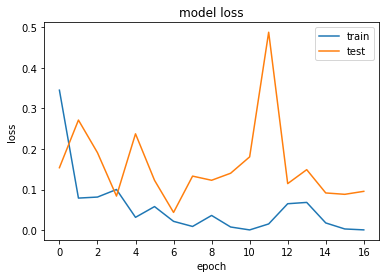

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

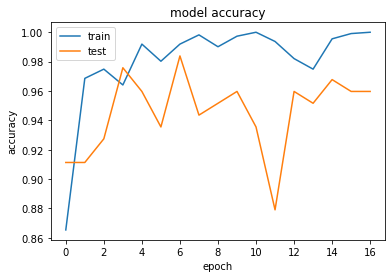

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **6. JSON 형식으로 파일 저장**
* 모델 구성 json으로 저장

In [29]:
model_json = model.to_json()
with open("covid_classifier_model.json","w") as json_file:
  json_file.write(model_json)

# **7. 모델 평가**
* 저장한 모델 평가를 위한 모델 불러오기

In [30]:
with open('covid_classifier_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('covid_classifier_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [31]:
predictions = model.predict(X_val)

* 예측 데이터 확인

In [32]:
predictions.shape

(124, 3)

* 모델 예측 시작

In [33]:
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

* 모델 정확도 확인

In [34]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, predict)
accuracy

from sklearn.metrics import classification_report

report = classification_report(y_val, predict)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.91      1.00      0.95        20
           2       1.00      0.96      0.98        50

    accuracy                           0.98       124
   macro avg       0.97      0.99      0.98       124
weighted avg       0.99      0.98      0.98       124



* 혼동행렬 확인

<AxesSubplot:>

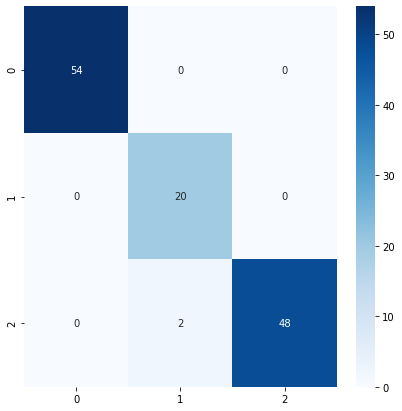

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')